In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df=pd.read_csv("/content/depression_dataset_reddit_cleaned.csv")
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depressioncheck in post a place t...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df["is_depression"].value_counts()

0    3900
1    3831
Name: is_depression, dtype: int64

<Axes: >

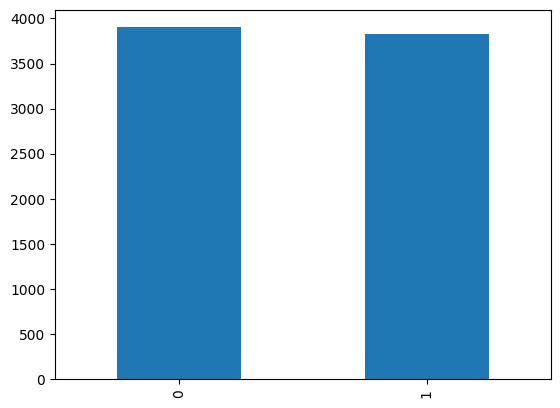

In [ ]:
df["is_depression"].value_counts().plot(kind="bar")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [ ]:
from wordcloud import WordCloud

In [ ]:
depressed_text = " ".join(df[df['is_depression'] == 1]['clean_text'])
not_depressed_text = " ".join(df[df['is_depression'] == 0]['clean_text'])

# Create WordCloud objects for both categories
depressed_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(depressed_text)
not_depressed_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(not_depressed_text)

(-0.5, 799.5, 399.5, -0.5)

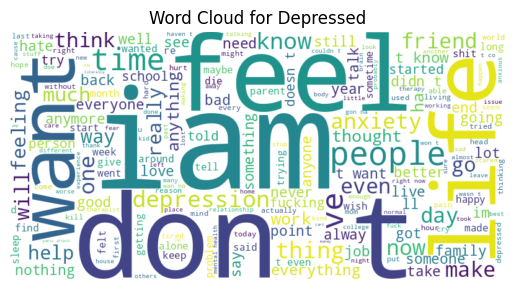

In [ ]:
plt.imshow(depressed_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Depressed')
plt.axis('off')

(-0.5, 799.5, 399.5, -0.5)

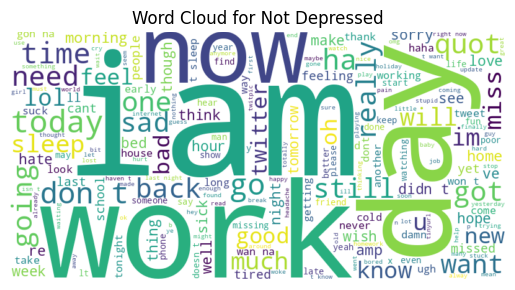

In [ ]:
plt.imshow(not_depressed_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Not Depressed')
plt.axis('off')

In [ ]:
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

In [ ]:
# nltk.download("all")

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

Removing stopwords and using lemmatizer

In [ ]:
w=WordNetLemmatizer()
for i in range(len(df)):
  review=re.sub('[^a-zA-Z]', ' ', df["clean_text"][i])
  review=review.lower()
  review=review.split()
  review=[w.lemmatize(word) for word in review if not word in set(stopwords.words("english"))]
  review=" ".join(review)
  df["clean_text"][i]=review
df.head()

<ipython-input-14-1da4c1537d5e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_text"][i]=review


,clean_text,is_depression
0,understand people reply immediately op invitat...,1
1,welcome r depressioncheck post place take mome...,1
2,anyone else instead sleeping depressed stay ni...,1
3,kind stuffed around lot life delaying inevitab...,1
4,sleep greatest comforting escape whenever wake...,1


Finding out vocabulary size of the dataset, by counting unique words

In [ ]:
s=set()
for i in range(len(df)):
    k=df["clean_text"][i].split()
    for j in range(len(k)):
        s.add(k[j])
len(s)

19984

Finding out one hot representaion of each sentence

In [ ]:
voc_size=19984
onehot_repr1=[one_hot(words,voc_size)for words in df["clean_text"]]

In [ ]:
max=0
for i in onehot_repr1:
    if len(i)>max:
        max=len(i)
max

1901

Converting one hot encodings to word embeddings

In [ ]:
sent_length=max
embedded_docs1=pad_sequences(onehot_repr1,padding='pre',maxlen=sent_length)

In [ ]:
Y=df["is_depression"]

In [ ]:
Y.shape

(7731,)

In [ ]:
embedded_docs1.shape

(7731, 1901)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(embedded_docs1,Y,test_size=0.2,random_state=10,stratify=Y)

In [ ]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(6184, 1901) (6184,) (1547, 1901) (1547,)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=voc_size, output_dim=128, input_length=sent_length))

# Convolutional layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

# Flatten the output
model.add(Flatten())

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so using sigmoid activation

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1901, 128)         2557952   
                                                                 
 conv1d (Conv1D)             (None, 1899, 64)          24640     
                                                                 
 max_pooling1d (MaxPooling1  (None, 949, 64)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 949, 64)           33024     
                                                                 
 dropout (Dropout)           (None, 949, 64)           0         
                                                                 
 flatten (Flatten)           (None, 60736)             0         
                                                        

In [ ]:
model_history = model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=5,batch_size=16)

Epoch 1/5
387/387 [==============================] - 76s 181ms/step - loss: 0.2392 - accuracy: 0.9065 - val_loss: 0.1693 - val_accuracy: 0.9502
Epoch 2/5
387/387 [==============================] - 37s 95ms/step - loss: 0.1025 - accuracy: 0.9643 - val_loss: 0.1333 - val_accuracy: 0.9548
Epoch 3/5
387/387 [==============================] - 27s 69ms/step - loss: 0.0523 - accuracy: 0.9822 - val_loss: 0.1665 - val_accuracy: 0.9489
Epoch 4/5
387/387 [==============================] - 20s 52ms/step - loss: 0.0254 - accuracy: 0.9901 - val_loss: 0.2337 - val_accuracy: 0.9354
Epoch 5/5
387/387 [==============================] - 18s 47ms/step - loss: 0.0397 - accuracy: 0.9875 - val_loss: 0.3055 - val_accuracy: 0.9341


In [ ]:
# Predictions on the Test Set

score = model.evaluate(X_test, Y_test, verbose=1)

49/49 [==============================] - 1s 15ms/step - loss: 0.3055 - accuracy: 0.9341


In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.30552855134010315
Test Accuracy: 0.9340659379959106


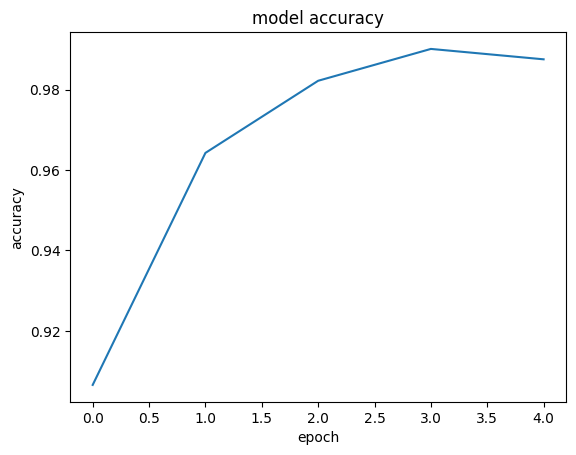

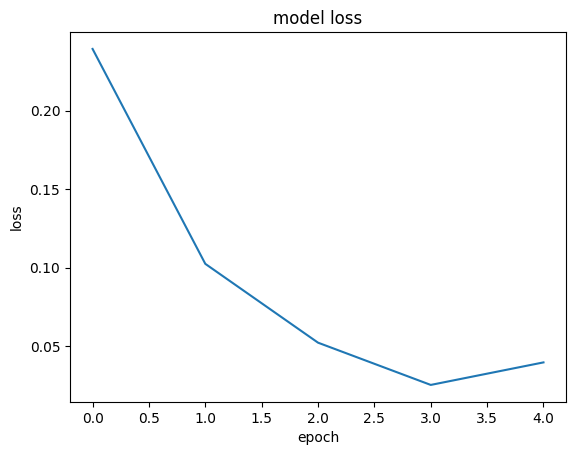

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(model_history.history['accuracy'])


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(model_history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
Y_pred=model.predict(X_test)
Y_pred=(Y_pred>=0.5).astype("int")
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))
print(confusion_matrix(Y_test,Y_pred))

49/49 [==============================] - 2s 19ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       780
           1       0.93      0.94      0.93       767

    accuracy                           0.93      1547
   macro avg       0.93      0.93      0.93      1547
weighted avg       0.93      0.93      0.93      1547

[[723  57]
 [ 45 722]]


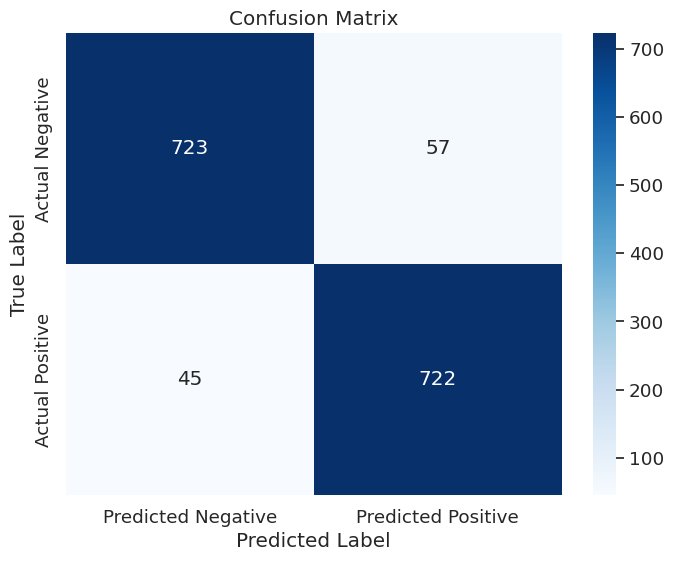

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


confusion_matrix = [[723, 57], [45, 722]]


labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']


confusion_matrix = np.array(confusion_matrix).reshape(2, 2)


plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


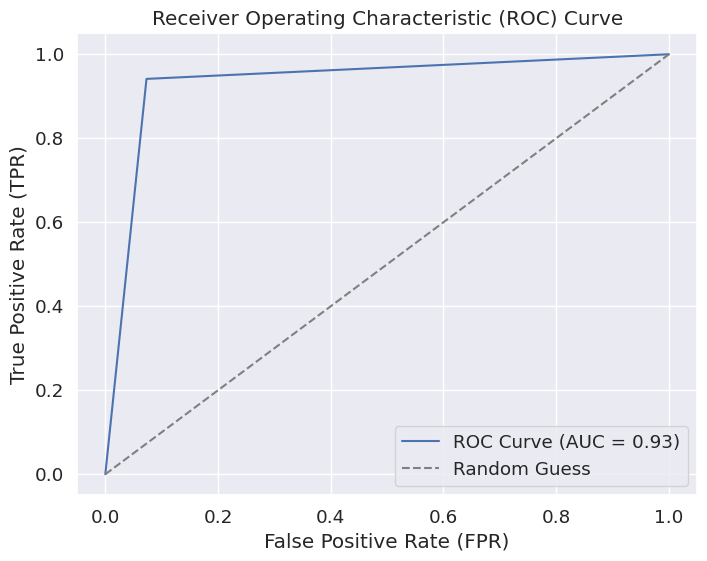

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

# AUC (Area Under the Curve)
auc = roc_auc_score(Y_test, Y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
